Necessary libraries for this project


In [4]:
import numpy as np
import pywt
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import os
import shutil
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sn


## Testing faces and eyes detection

In [11]:
img= cv2.imread("./test_images/captcha7.png")
img.shape

(1027, 1520, 3)

In [12]:
# Convert the image to grayscale using OpenCV's cvtColor function
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1027, 1520)

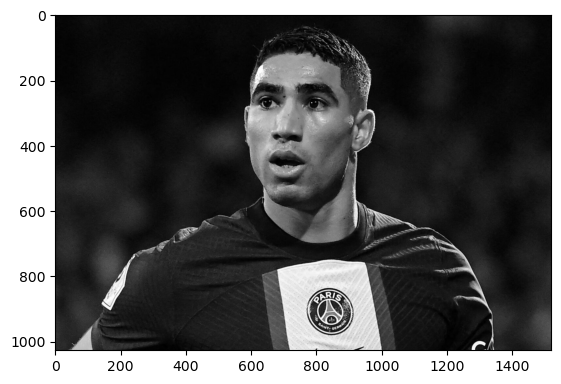

In [13]:
plt.imshow(gray, cmap='gray')

##### Detect faces in the input image using the detectMultiScale function of the face cascade classifier
- the detectMultiScale function detects objects (in this case, faces) of different sizes in the input image
##### Parameters:
   - img: Input image in which faces are to be detected
   - scaleFactor: Parameter specifying how much the image size is reduced at each image scale
   - minNeighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it

The function returns a list of rectangles representing the detected faces

In [14]:
# Create a face cascade classifier object by loading the pre-trained Haar cascade classifier XML file
face_cascade = cv2.CascadeClassifier('./opencv_haarcascades/haarcascade_frontalface_default.xml')
# Create an eye cascade classifier object by loading the pre-trained Haar cascade classifier XML file
eye_cascade = cv2.CascadeClassifier('./opencv_haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(img, 1.3, 5)
faces

face_cascade = cv2.CascadeClassifier('./opencv_haarcascades/haarcascade_frontalface_default.xml')

# Create an eye cascade classifier object by loading the pre-trained Haar cascade classifier XML file
eye_cascade = cv2.CascadeClassifier('./opencv_haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(img, 1.3, 5)

# Print the list of rectangles representing the detected faces
faces


array([[512,  94, 422, 422]])

In [15]:
(x,y,w,h) = faces[0]
x,y,w,h

(512, 94, 422, 422)

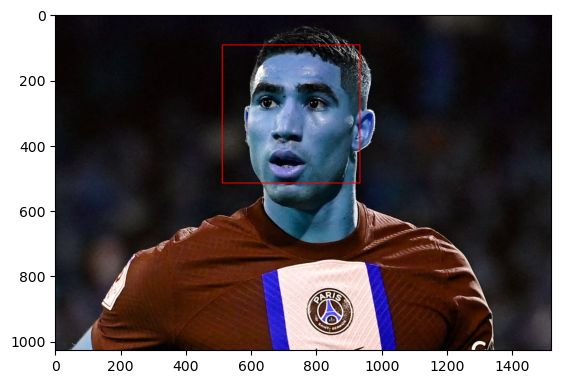

In [16]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

### Detecting faces and eyes in an image using OpenCV. 
we initialize Haar cascade classifiers for face and eye detection and applies them to the image. Detected faces are enclosed in rectangles, and for each detected face, the code identifies regions of interest **(ROI)** corresponding to the face and the eyes within it. 

Rectangles are drawn around the eyes, and the modified image with annotated faces and eyes is visualized using matplotlib.

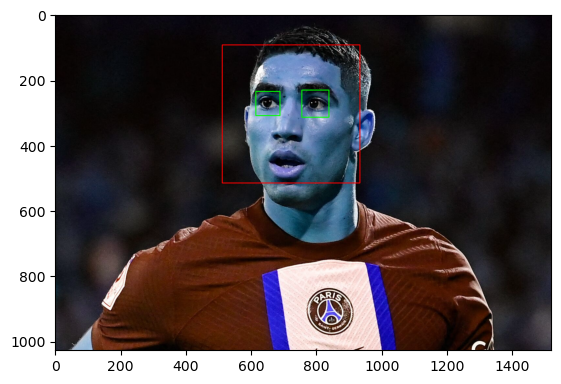

In [17]:
#cv2.destroyAllWindows() (only used if i visualize images with cv2.imshow(), cause it creats window for figure and keep it open)
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    #to detect eyes
    roi_gray = gray[y:y+h, x:x+w]
    #to creat rectangles around eyes
    roi_color = face_img[y:y+h, x:x+w]
    #detect eyes in gray img within the detected face area
    eyes = eye_cascade.detectMultiScale(roi_gray)
    #draw rectangle for eyes withing the face rectangle
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

#plt.figure()
plt.imshow(face_img,cmap='gray')
#plt.show()

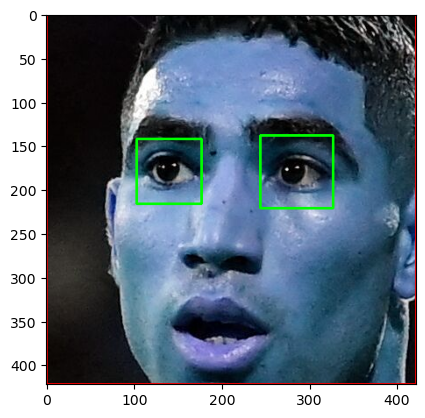

In [18]:
plt.imshow(roi_color,cmap="gray")

In [19]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

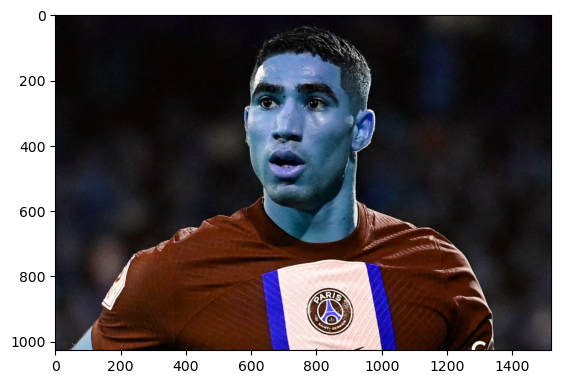

In [22]:
original_image=cv2.imread("./test_images/captcha7.png")
plt.imshow(original_image)

In [24]:
cropped_image=get_cropped_image_if_2_eyes("./test_images/captcha7.png")

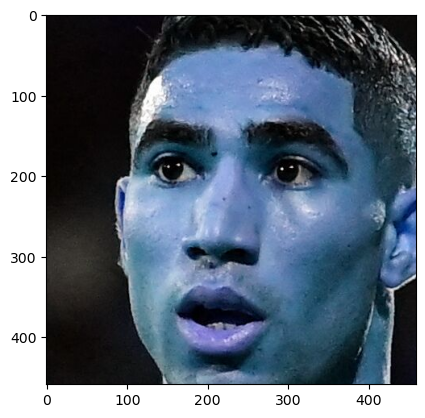

In [25]:
plt.imshow(cropped_image)

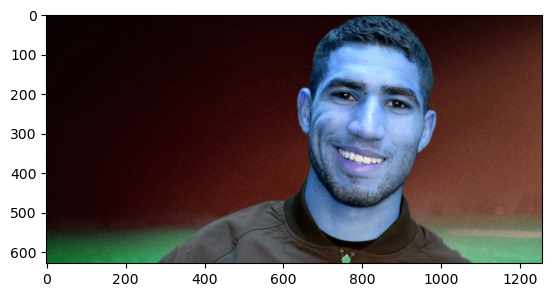

In [26]:
original_image=cv2.imread("./test_images/captcha3.png")
plt.imshow(original_image)

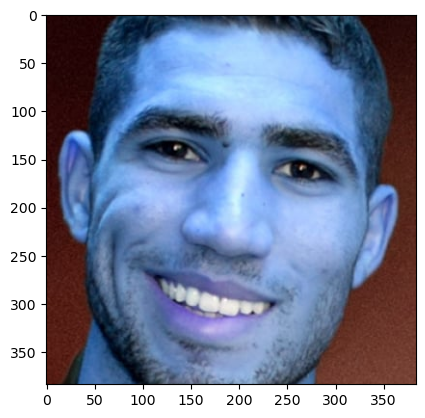

In [27]:
plt.imshow(get_cropped_image_if_2_eyes("./test_images/captcha3.png"))

## Creating a new folder containing cropped faces only

In [36]:
path_to_data="./dataset2/"
path_to_cr_data= "./dataset2/cropped/"

In [37]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [38]:
img_dirs

['./dataset2/cristiano ronaldo',
 './dataset2/hakimi',
 './dataset2/lebron james',
 './dataset2/lewis hamilton',
 './dataset2/messi']

In [39]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [40]:
cropped_image_dirs=[]
celebrity_file_names_dict={}

for img_dir in img_dirs:
    count=1
    celebrity_name= img_dir.split("/")[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name]=[]
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)

            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 

            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    


cristiano ronaldo
Generating cropped images in folder:  ./dataset2/cropped/cristiano ronaldo
hakimi
Generating cropped images in folder:  ./dataset2/cropped/hakimi
lebron james
Generating cropped images in folder:  ./dataset2/cropped/lebron james
lewis hamilton
Generating cropped images in folder:  ./dataset2/cropped/lewis hamilton
messi
Generating cropped images in folder:  ./dataset2/cropped/messi


## Feature engineering

In [42]:
celebrity_file_names_dict.keys()

dict_keys(['cristiano ronaldo', 'hakimi', 'lebron james', 'lewis hamilton', 'messi'])

In [22]:
# wavelet transformation
#del celebrity_file_names_dict["cropped"]

This function takes an input image (img) and performs a wavelet transform using the specified wavelet mode (mode) and decomposition level (level). 

In [43]:

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

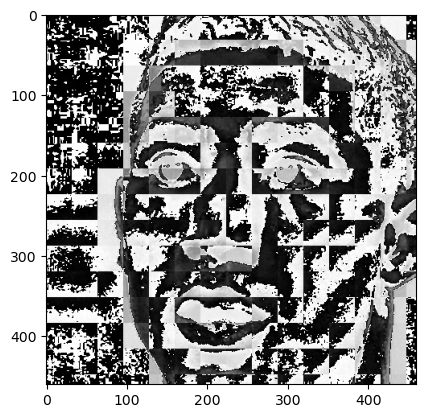

In [44]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [45]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'cristiano ronaldo': 0,
 'hakimi': 1,
 'lebron james': 2,
 'lewis hamilton': 3,
 'messi': 4}

In [71]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])   

In [72]:
len(X)


308

In [73]:
len(X[0])

4096

In [74]:
x=np.array(X).reshape(len(X),4096).astype(float)
x.shape

(308, 4096)

## Model training

This code segment involves splitting the dataset into training and testing sets using the train_test_split function and then fitting a Support Vector Classifier (SVC) model to the training data using a pipeline that includes feature scaling and the SVC algorithm. 

- **train_test_split** function: This function divides the dataset (x and y) into two subsets: a training set (X_train, y_train) and a testing set (X_test, y_test). The random_state=0 parameter ensures reproducibility by fixing the random seed for the data splitting process.

- **Pipeline construction**: The Pipeline class from scikit-learn is used to chain together multiple processing steps. In this case, the pipeline consists of two steps:
   *  Feature scaling: The data is standardized using StandardScaler(), which removes the mean and scales the data to unit variance.
   *  Support Vector Classifier (SVC): The scaled features are passed to an SVC model with a radial basis function (RBF) kernel (kernel='rbf') and a regularization parameter C=10.

- **Model fitting**: The pipeline (pipe) is trained on the training data (X_train, y_train) using the fit method. This process involves scaling the features and training the SVC model.
- **Model evaluation**: The score method of the pipeline is called on the testing data (X_test, y_test) to evaluate the performance of the trained model on unseen data. This method returns the accuracy of the model predictions on the test set.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8181818181818182

In [77]:
pipe.predict(X_test)

array([0, 4, 4, 0, 3, 2, 4, 3, 0, 1, 4, 1, 3, 0, 0, 3, 3, 3, 3, 4, 3, 1,
       1, 0, 3, 0, 1, 3, 2, 1, 2, 1, 2, 3, 3, 2, 3, 3, 2, 3, 0, 3, 2, 0,
       2, 0, 3, 2, 1, 3, 3, 2, 3, 1, 3, 2, 4, 0, 1, 0, 0, 4, 0, 0, 1, 1,
       4, 4, 4, 2, 1, 1, 1, 4, 1, 0, 4])

In [78]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.81      0.81      0.81        16
           2       0.83      0.77      0.80        13
           3       0.76      0.89      0.82        18
           4       0.83      0.83      0.83        12

    accuracy                           0.82        77
   macro avg       0.82      0.82      0.82        77
weighted avg       0.82      0.82      0.82        77



## Gridsearch

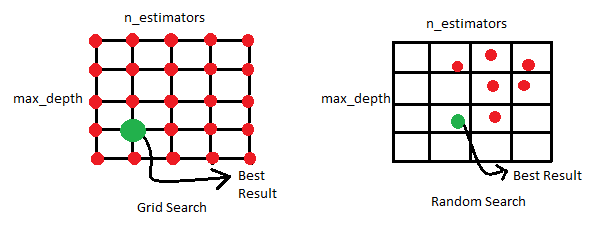


This `model_params` dictionary defines different machine learning models along with their corresponding hyperparameters that will be used for hyperparameter tuning. Here's a breakdown of its structure:

- **svm**: Support Vector Machine (SVM) model
  - **model**: An instance of the `svm.SVC` class initialized with `gamma='auto'` and `probability=True`.
  - **params**: A dictionary specifying the hyperparameters to be tuned for the SVM model:
    - `'svc__C'`: The regularization parameter `C` for the SVM classifier, with possible values `[1, 10, 100, 1000]`.
    - `'svc__kernel'`: The kernel function to be used by the SVM classifier, with possible values `['rbf', 'linear']`.

- **random_forest**: Random Forest model:
  - **model**: An instance of the `RandomForestClassifier` class.
  - **params**: A dictionary specifying the hyperparameters to be tuned for the Random Forest model:
    - `'randomforestclassifier__n_estimators'`: The number of trees in the forest, with possible values `[1, 5, 10]`.

- **logistic_regression**: Logistic Regression model:
  - **model**: An instance of the `LogisticRegression` class initialized with `solver='liblinear'` and `multi_class='auto'`.
  - **params**: A dictionary specifying the hyperparameters to be tuned for the Logistic Regression model:
    - `'logisticregression__C'`: The inverse regularization strength `C` for the logistic regression model, with possible values `[1, 5, 10]`.


In [155]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },
    'xgboost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'xgbclassifier__n_estimators': [10, 50, 100],
            'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],
            'xgbclassifier__max_depth': [4, 6, 8]
        }
    }
}

In [158]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
   
    pipe1 = make_pipeline(StandardScaler(), mp['model'])
    
    clf =  GridSearchCV(pipe1, mp['params'], cv=5, return_train_score=True)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.878908,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.701203,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.857539,{'logisticregression__C': 1}


In [168]:
clf.cv_results_

{'mean_fit_time': array([3.06367211, 2.41509933, 1.94783783]),
 'std_fit_time': array([0.04950492, 0.84373729, 0.18264505]),
 'mean_score_time': array([0.00461025, 0.00335364, 0.00285244]),
 'std_score_time': array([0.00048038, 0.00168461, 0.0007699 ]),
 'param_logisticregression__C': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregression__C': 1},
  {'logisticregression__C': 5},
  {'logisticregression__C': 10}],
 'split0_test_score': array([0.76595745, 0.76595745, 0.76595745]),
 'split1_test_score': array([0.84782609, 0.84782609, 0.84782609]),
 'split2_test_score': array([0.91304348, 0.91304348, 0.91304348]),
 'split3_test_score': array([0.93478261, 0.93478261, 0.93478261]),
 'split4_test_score': array([0.82608696, 0.82608696, 0.82608696]),
 'mean_test_score': array([0.85753932, 0.85753932, 0.85753932]),
 'std_test_score': array([0.06085733, 0.06085733, 0.06085733]),
 'rank_test_score'

In [144]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'xgboost': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('xgbclassifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='logloss',
   

In [145]:
best_estimators["svm"].score(X_test,y_test)

0.8311688311688312

In [146]:
best_estimators["random_forest"].score(X_test,y_test)

0.5974025974025974

In [147]:
best_clf=best_estimators["logistic_regression"]
best_estimators["logistic_regression"].score(X_test,y_test)


0.8311688311688312

In [148]:
best_clf=best_estimators["xgboost"]
best_estimators["xgboost"].score(X_test,y_test)

0.7662337662337663

In [149]:

cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[12,  3,  0,  1,  2],
       [ 2, 12,  1,  1,  0],
       [ 0,  0, 13,  0,  0],
       [ 0,  0,  3, 14,  1],
       [ 1,  1,  1,  1,  8]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

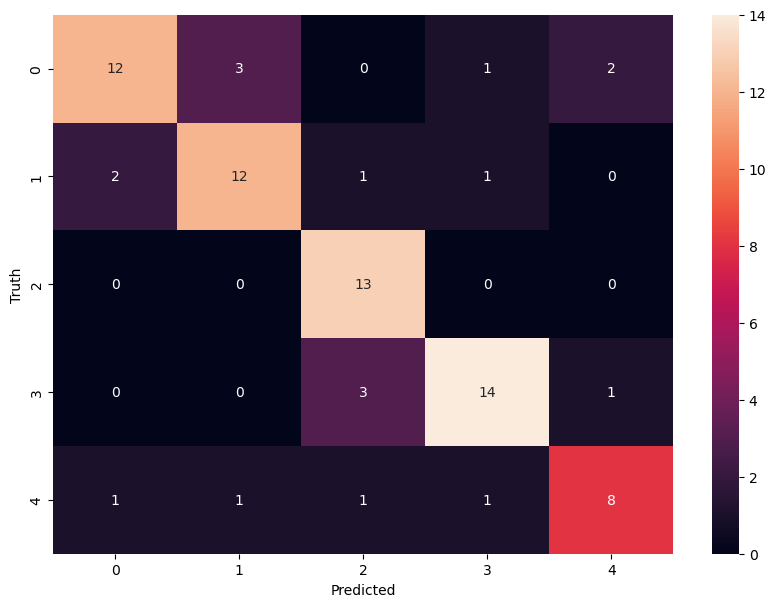

In [150]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [151]:
## prediction:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    #print(faces)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        #print(eyes)
        if len(eyes) >= 2:
            return roi_color
        
def preprocessing(path):
    img1=get_cropped_image_if_2_eyes(path)
    cv2.imwrite("./cropped_to_predict/"+path.split('/')[-1], img1)
    #print("./cropped_to_predict/"+path.split('/')[-1])

    img=cv2.imread("./cropped_to_predict/"+path.split('/')[-1])
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    X=[combined_img]
    img_to_predict=np.array(X).reshape(len(X),len(X[0])).astype(float)
    return(img_to_predict)


## Use model 

In [154]:
path_list=os.listdir("./predict_images/")
print(path_list)
count=0
labels={}
for k,v in class_dict.items():
    labels[v]=k

for path in path_list:
    try:
        result=best_estimators["logistic_regression"].predict(preprocessing("./predict_images/"+path))
        
        print("it is ",labels[result[0]])
        count=count+1
            
    except:
        #print("error in ",path)
        continue
print("number of image detected is ", count," out of ",len(path_list))

['cr10.jpg', 'cr11.jpg', 'cr2.jpg', 'cr3.jpg', 'cr4.jpg', 'cr5.jpg', 'cr6.jpg', 'cr7.jpg', 'cr8.jpg', 'cr9.jpg']
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  cristiano ronaldo
it is  hakimi
number of image detected is  8  out of  10


## Save the trained model

In [ ]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [115]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))